# Feature Sieve for Behavioral Cloning

## Atari Game: Space Invaders(D4RL)

In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import gymnasium as gym
from tqdm import tqdm
import sys
import os
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

In [2]:
#Setting random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "CPU")

In [3]:
# creating the environment to suit the dataset
env = gym.make("SpaceInvadersNoFrameskip-v4")
env = gym.wrappers.GrayScaleObservation(env, keep_dim=False)
env = gym.wrappers.ResizeObservation(env, (84, 84))
env = gym.wrappers.FrameStack(env, 4)

#Environment Infos
print(f"Observation Space: {env.observation_space.shape}")
print(f"Action Space: {env.action_space.n}")

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


Observation Space: (4, 84, 84)
Action Space: 6


In [4]:
#Loading the Dataset
OBSERVATION_DIR = "./Datasets/Observations/"
ACTIONS_DIR = "./Datasets/Actions/"

observations = np.load("./Datasets/space_invaders_obs.npy")
actions = np.load("./Datasets/space_invaders_actions.npy")
actions = actions.reshape((-1,))

print(observations.shape)
print(actions.shape)

(1000000, 4, 84, 84)
(1000000,)


In [5]:
class AtariDataset(Dataset):
    def __init__(self, observations, actions):
        self.observations = observations
        self.actions = actions

    def __getitem__(self, index):
        obs = self.observations[index]
        action = self.actions[index]
        return obs, action

    def __len__(self):
        return self.observations.shape[0]

In [6]:
#Datapoints for the dataset
TRAIN_DATAPTS = int(0.95 * observations.shape[0])
VAL_DATAPTS = int(0.025 * observations.shape[0])
TEST_DATAPTS = int(0.025 * observations.shape[0])

print(f"Training Dataset size: {TRAIN_DATAPTS}")
print(f"Test Dataset Size :{TEST_DATAPTS}")
print(f"Validation Dataset Size: {VAL_DATAPTS}")

#Spiting Observations and Actions
train_observations = observations[:TRAIN_DATAPTS]
val_observations = observations[TRAIN_DATAPTS: TRAIN_DATAPTS + VAL_DATAPTS]
test_observations = observations[TRAIN_DATAPTS + VAL_DATAPTS: ]

train_actions = actions[:TRAIN_DATAPTS]
val_actions = actions[TRAIN_DATAPTS: TRAIN_DATAPTS + VAL_DATAPTS]
test_actions = actions[TRAIN_DATAPTS + VAL_DATAPTS: ]

#Datasets
train_dataset = AtariDataset(train_observations, train_actions)
val_dataset = AtariDataset(val_observations, val_actions)
test_dataset = AtariDataset(test_observations, test_actions)

#DataLoaders
train_dataloader = DataLoader(dataset = train_dataset, shuffle = True, batch_size=128)
val_dataloader = DataLoader(dataset = val_dataset, shuffle = True, batch_size = 128)
test_dataloader = DataLoader(dataset = test_dataset, shuffle = True, batch_size = 128)

Training Dataset size: 950000
Test Dataset Size :25000
Validation Dataset Size: 25000


In [7]:
# Early Stopping 
class Early_Stopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.max_validation_acc = float('-inf')

    def early_stop(self, validation_acc):
        if validation_acc > self.max_validation_acc:
            self.max_validation_acc = validation_acc
            self.counter = 0
        elif validation_acc < (self.max_validation_acc - self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

# CNN Model
A Simple CNN model from the DQN paper

In [8]:
class CNN(nn.Module):
    def __init__(self, num_channels, num_actions):
        super(CNN, self).__init__()
        self.num_actions = num_actions

        self.conv1 = nn.Conv2d(num_channels, 32, 8, stride=4)
        self.batchnorm1 = nn.BatchNorm2d(num_features = 32)
        self.conv2 = nn.Conv2d(32, 64, 4, stride=2)
        self.batchnorm2 = nn.BatchNorm2d(num_features = 64)
        self.conv3 = nn.Conv2d(64, 64, 3, stride=1)
        self.batchnorm3 = nn.BatchNorm2d(num_features = 64)

        self.fc1 = nn.Linear(3136, 512)
        self.fc2 = nn.Linear(512, num_actions)

    def forward(self, x):
        x = self.batchnorm1(F.relu(self.conv1(x)))
        x = self.batchnorm2(F.relu(self.conv2(x)))
        x = self.batchnorm3(F.relu(self.conv3(x)))
        
        x = x.reshape((x.shape[0], -1))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

In [9]:
# Training function
def train_cnn(model, train_dataloader, val_dataloader, epochs = 100, lr =1e-3, wd= 1e-5, verbose = True, early_stop = False, patience = 3, min_delta = 0.1):
    optimizer = optim.Adam(model.parameters(), lr = lr, weight_decay = wd)

    if verbose:
        print("Training Model...............")
    if early_stop:
        early_stopper = Early_Stopper(patience = patience, min_delta = min_delta)
    
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    for epoch in tqdm(range(epochs)):
        tloss = 0
        tloss_num = 0
        correct = 0
        total = 0
        
        model.train()
        for batch_idx, data in enumerate(train_dataloader):
            x, y = data
            x = x.to(torch.float32).to(device)
            y = y.to(torch.long).to(device)

            optimizer.zero_grad()
            out = model(x)
            loss = F.cross_entropy(out, y)
            loss.backward()
            optimizer.step()

            tloss += loss.detach().cpu()
            tloss_num += 1

            _, preds = torch.max(out.data, 1)
            correct += (preds == y).sum().item()
            total += y.shape[0]

        with torch.no_grad():
            vloss = 0
            vloss_num = 0
            vcorrect = 0
            vtotal = 0

            for batch_idx, data in enumerate(val_dataloader):
                x, y = data
                x = x.to(torch.float32).to(device)
                y = y.to(torch.long).to(device)

                out = model(x)
                loss = F.cross_entropy(out, y)

                vloss += loss.detach().cpu()
                vloss_num +=1

                _, preds = torch.max(out.data, 1)
                vcorrect += (preds == y).sum().item()
                vtotal += y.shape[0]

        train_losses.append(float(tloss / tloss_num))
        train_accs.append(float(correct/total))
        val_losses.append(float(vloss / vloss_num))
        val_accs.append(float(vcorrect / vtotal))

        if verbose:
            print(f"Epoch :{epoch}/{epochs}")
            print(f"Training Loss: {tloss / tloss_num} Accuracy: {correct / total}")
            print(f"Validation Loss: {vloss / vloss_num} Accuracy: {vcorrect / total}")

        if early_stop:
            if early_stopper.early_stop(vcorrect / total):
                break

    return model, train_losses, train_accs, val_losses, val_accs

def eval_cnn(model, test_dataloader):
    model.eval()
    tloss = 0
    tloss_num = 0
    total = 0
    correct = 0

    for batch_idx, data in enumerate(test_dataloader):
        x, y = data
        x = x.to(torch.float32).to(device)
        y = y.to(torch.long).to(device)

        out = model(x)
        loss = F.cross_entropy(out, y)

        tloss += loss.detach().cpu()
        tloss_num += 1

        _, preds = torch.max(out.data, 1)
        total += y.shape[0]
        correct += (preds == y).sum().item()

    print(f"Test Loss: {tloss / tloss_num} Accuracy:{correct / total}")
    return tloss / tloss_num, correct / total

In [10]:
def plot_loss_curves(train_loss, val_loss, test_loss, model_name, metric = "loss", epochs = 100):
    plt.plot(range(epochs), train_loss, color = "blue", label = f"Training {metric}")
    plt.plot(range(epochs), val_loss, color = "red", label = f"Validation {metric}")
    plt.plot(range(epochs), [test_loss] * epochs, color = "green", label = f"Test {metric}")
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.title(model_name)
    plt.legend()
    plt.show()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [1:48:06<00:00, 64.86s/it]


Test Loss: 1.366586685180664 Accuracy:0.43064


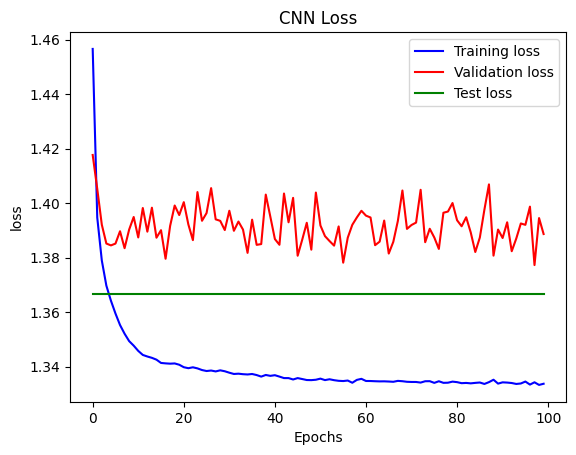

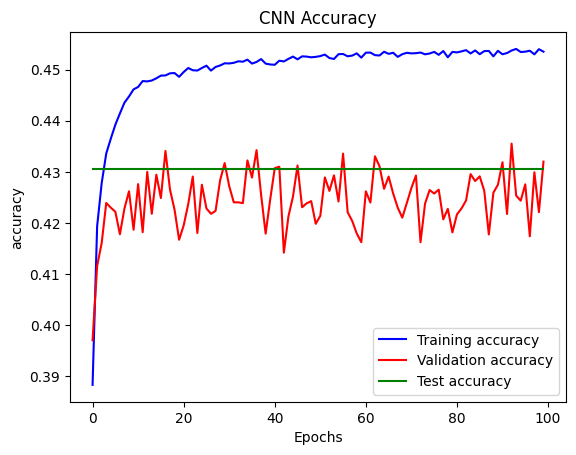

In [11]:
epochs = 100
model = CNN(4, 6).to(device)
model, train_loss, train_acc, val_loss, val_acc = train_cnn(model, train_dataloader, val_dataloader, epochs = epochs, wd=1e-3, verbose = False, early_stop = True, min_delta = 0.1)
test_loss, test_acc = eval_cnn(model, test_dataloader)

plot_loss_curves(train_loss, val_loss, test_loss, epochs = epochs, model_name = "CNN Loss", metric = "loss")
plot_loss_curves(train_acc, val_acc, test_acc, epochs = epochs, model_name = "CNN Accuracy", metric = "accuracy")

In [14]:
#Hyperparameter Tuning
lrs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
wds = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

test_accs = np.zeros((len(lrs), len(wds)))
test_losses = np.zeros((len(lrs), len(wds)))

for i in range(len(lrs)):
    for j in range(len(wds)):
        print(f"LR: {lrs[i]} WD:{wds[j]}")
        model = CNN(4, 6).to(device)
        model, train_loss, train_acc, val_loss, val_acc = train_cnn(model, train_dataloader, val_dataloader, epochs = 10, verbose = False, lr = lrs[i], wd = wds[j])
        test_loss,  test_acc = eval_cnn(model, test_dataloader)

        test_losses[i,j] = test_loss
        test_accs[i,j] = test_acc

best_lr, best_wd = np.unravel_index(np.min(test_losses), test_losses)
best_lr_, best_wd_ = np.unravel_index(np.min(test_accs), test_accs)

print(f"Best LR: {best_lr} Best WD: {best_wd} with respect to test loss")
print(f"Best LR: {best_lr_} Best WD: {best_wd_} with respect to test accuracy")

LR: 1e-05 WD:1e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [10:50<00:00, 65.07s/it]


Test Loss: 1.423556923866272 Accuracy:0.41088
LR: 1e-05 WD:1e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [11:02<00:00, 66.27s/it]


Test Loss: 1.4321308135986328 Accuracy:0.40836
LR: 1e-05 WD:1e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [10:53<00:00, 65.30s/it]


Test Loss: 1.4216750860214233 Accuracy:0.41524
LR: 1e-05 WD:1e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [10:48<00:00, 64.82s/it]


Test Loss: 1.4088143110275269 Accuracy:0.4096
LR: 1e-05 WD:1e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [10:45<00:00, 64.56s/it]


Test Loss: 1.4474503993988037 Accuracy:0.40044
LR: 0.0001 WD:0.0001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [10:44<00:00, 64.45s/it]


Test Loss: 1.9755665063858032 Accuracy:0.37596
LR: 0.0001 WD:0.0001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [10:40<00:00, 64.08s/it]


Test Loss: 1.9531080722808838 Accuracy:0.3686
LR: 0.0001 WD:0.0001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [10:50<00:00, 65.07s/it]


Test Loss: 1.5408586263656616 Accuracy:0.40716
LR: 0.0001 WD:0.0001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [11:07<00:00, 66.71s/it]


Test Loss: 1.3750466108322144 Accuracy:0.41928
LR: 0.0001 WD:0.0001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [10:58<00:00, 65.87s/it]


Test Loss: 1.515895962715149 Accuracy:0.3448
LR: 0.001 WD:0.001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [10:55<00:00, 65.56s/it]


Test Loss: 1.5715885162353516 Accuracy:0.40856
LR: 0.001 WD:0.001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [11:02<00:00, 66.29s/it]


Test Loss: 1.3961756229400635 Accuracy:0.42932
LR: 0.001 WD:0.001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [10:55<00:00, 65.53s/it]


Test Loss: 1.371903896331787 Accuracy:0.42756
LR: 0.001 WD:0.001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [11:01<00:00, 66.11s/it]


Test Loss: 1.4484745264053345 Accuracy:0.38492
LR: 0.001 WD:0.001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [10:57<00:00, 65.77s/it]


Test Loss: 1.6476225852966309 Accuracy:0.30344
LR: 0.01 WD:0.01


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [10:54<00:00, 65.46s/it]


Test Loss: 1.7869991064071655 Accuracy:0.1838
LR: 0.01 WD:0.01


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [11:04<00:00, 66.46s/it]


Test Loss: 1.500490665435791 Accuracy:0.34772
LR: 0.01 WD:0.01


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [11:08<00:00, 66.83s/it]


Test Loss: 1.5160481929779053 Accuracy:0.36808
LR: 0.01 WD:0.01


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [10:59<00:00, 65.90s/it]


Test Loss: 1.6489222049713135 Accuracy:0.30956
LR: 0.01 WD:0.01


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [10:37<00:00, 63.71s/it]


Test Loss: 1.788910984992981 Accuracy:0.18224
LR: 0.1 WD:0.1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [11:25<00:00, 68.57s/it]


Test Loss: 3022.29296875 Accuracy:0.18208
LR: 0.1 WD:0.1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [10:56<00:00, 65.70s/it]


Test Loss: 113.28730773925781 Accuracy:0.17872
LR: 0.1 WD:0.1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [10:57<00:00, 65.71s/it]


Test Loss: 1.8977649211883545 Accuracy:0.15676
LR: 0.1 WD:0.1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [11:07<00:00, 66.74s/it]


Test Loss: 1.7958368062973022 Accuracy:0.15668
LR: 0.1 WD:0.1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [10:55<00:00, 65.57s/it]


Test Loss: 1.7911336421966553 Accuracy:0.18224


TypeError: only integer scalar arrays can be converted to a scalar index

In [11]:
# Finetuned model
model = CNN(4, 6).to(device)
model, train_loss, train_accs, val_loss, val_accs = train_cnn(model, train_dataloader, val_dataloader, epochs =100, verbose = False, lr = 1e-3, wd = 1e-3)
test_loss, test_acc = eval_cnn(model, test_dataloader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [1:48:06<00:00, 64.87s/it]


Test Loss: 1.3730844259262085 Accuracy:0.42844


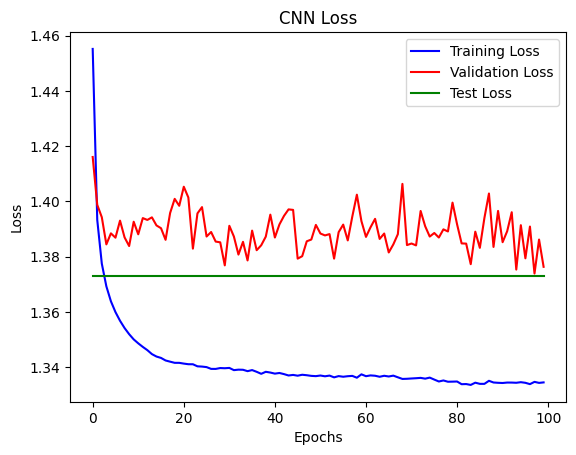

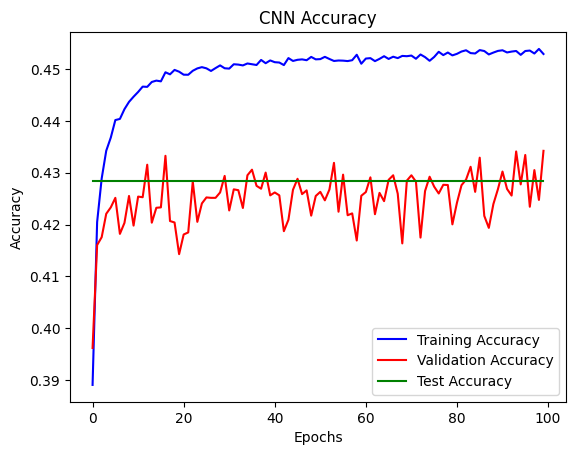

In [12]:
plot_loss_curves(train_loss, val_loss, test_loss, epochs =100, model_name = "CNN Loss", metric = "Loss")
plot_loss_curves(train_accs, val_accs, test_acc, epochs =100, model_name = "CNN Accuracy", metric = "Accuracy")

# Resnet Architecture
## Smallest ResNet variant: ResNet-18

In [11]:
# ResNet 18 model for Age Prediction
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

## Resnet Block
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

## ResNet
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes, in_channels):
        self.num_classes = num_classes
        self.inplanes = 64
        in_dim = in_channels
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1, padding=2)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        logits = F.softmax(self.fc(x), dim = -1)
        return logits

## ResNet 34 model
def resnet18(num_classes, in_channels):
    """Constructs a ResNet-34 model."""
    model = ResNet(block=BasicBlock,
                   layers=[2, 2, 2, 2],
                   num_classes=num_classes,
                   in_channels=in_channels)
    return model

In [ ]:
resnet_model = resnet18(6, 4).to(device)
resnet_model, train_loss, train_acc, val_loss, val_acc = train_cnn(resnet_model, train_dataloader, val_dataloader, epochs = 100)
test_loss, test_acc = eval_cnn(resnet_model, test_dataloader)

Training Model...............


  0%|                                                                                                                                                                     | 0/100 [00:00<?, ?it/s]

In [ ]:
plot_loss_curves(train_loss, val_loss, test_loss, epochs =100, model_name = "Resnet18 Loss", metric = "Loss")
plot_loss_curves(train_accs, val_accs, test_acc, epochs =100, model_name = "Resnet18 Accuracy", metric = "Accuracy")

# Feature Sieve Model
## Architecture 1
Auxilary network is connected to the 1st convolutional layer

In [11]:
class Feature_Sieve(nn.Module):
    def __init__(self, num_channels, num_actions):
        super(Feature_Sieve, self).__init__()
        self.num_actions = num_actions

        #Main Network
        self.conv1 = nn.Conv2d(num_channels, 32, 8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, 4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, 3, stride=1)

        self.fc1 = nn.Linear(3136, 512)
        self.fc2 = nn.Linear(512, num_actions)

        #Aux network
        self.aux_fc1 = nn.Linear(12800, 512)
        self.aux_fc2 = nn.Linear(512, num_actions)

        self.params = nn.ModuleDict(
            {
                "main" : nn.ModuleList([self.conv1, self.conv2, self.conv3, self.fc1, self.fc2]),
                "aux" : nn.ModuleList([self.aux_fc1, self.aux_fc2]),
                "forget" : nn.ModuleList([self.conv1])
            }
        )

    def forward(self, x):
        sh = F.relu(self.conv1(x))
        x = F.relu(self.conv2(sh))
        x = F.relu(self.conv3(x))
        
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        aux = sh.reshape(sh.shape[0], -1)
        aux = F.relu(self.aux_fc1(aux))
        aux = self.aux_fc2(aux)

        return x, aux

In [12]:
## Forgetting Loss: Cross Entropy
def learn_main(FS, optim_main, x, y):
    FS.train()
    optim_main.zero_grad()
    out = FS(x)[0]
    loss = F.cross_entropy(out, y)
    loss.backward()
    optim_main.step()
    optim_main.zero_grad()
    FS.eval()

def learn_aux(FS, optim_main, optim_aux, x, y, alpha_aux=1):
    FS.train()
    optim_main.zero_grad()
    aux = FS(x)[1]
    loss = alpha_aux * F.cross_entropy(aux, y)
    loss.backward()
    optim_aux.step()
    optim_aux.zero_grad()
    FS.eval()

def forget_aux(FS, optim_forget, x, num_bins):
    FS.train()
    optim_forget.zero_grad()
    aux = FS(x)[1]
    loss = F.cross_entropy(aux, torch.ones_like(aux) * 1/num_bins)
    loss.backward()
    optim_forget.step()
    optim_forget.zero_grad()
    FS.eval()

In [13]:
def train_fs(model, train_dataloader, val_dataloader, forget_iters = 5, aux_iters =1, main_iters =1, lrs = [0.0005, 0.0005, 0.0005],epochs = 100, verbose = False, early_stop = False, patience = 3, min_delta = 0.1):
    if verbose:
        print("Training Model..............")

    if early_stop:
        early_stopper = Early_Stopper(patience = patience, min_delta = min_delta)

    optim_main = optim.Adam(model.params.main.parameters(), lr = lrs[0])
    optim_aux = optim.Adam(model.params.aux.parameters(), lr = lrs[1])
    optim_forget = optim.Adam(model.params.forget.parameters(), lr = lrs[2])

    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    steps = 0
    for epoch in tqdm(range(epochs)):
        tloss = 0
        tloss_num = 0
        tcorrect = 0
        ttotal = 0

        for batch_idx, data in enumerate(train_dataloader):
            x, y = data
            x = x.to(torch.float32).to(device)
            y = y.to(torch.long).to(device)
        
            if main_iters and steps % main_iters == 0:
                learn_main(model, optim_main, x, y)
            if aux_iters and steps % aux_iters == 0:
                learn_aux(model, optim_main, optim_aux, x, y)
            if forget_iters and steps % forget_iters == 0:
                forget_aux(model, optim_forget, x, model.num_actions)

            with torch.no_grad():
                out = model(x)[0]
                loss = F.cross_entropy(out, y)
                tloss += loss.detach().cpu()
                tloss_num += 1

                _, preds = torch.max(out.data, 1)
                tcorrect += (preds == y).sum().item()
                ttotal += y.shape[0]
                steps += 1

        with torch.no_grad():
            vloss = 0
            vloss_num = 0
            vtotal = 0
            vcorrect = 0

            for batch_idx, data in enumerate(val_dataloader):
                x, y = data
                x = x.to(torch.float32).to(device)
                y = y.to(torch.long).to(device)

                out = model(x)[0]
                loss = F.cross_entropy(out, y)
                vloss += loss.detach().cpu()
                vloss_num += 1

                _, preds = torch.max(out.data, 1)
                vtotal += y.shape[0]
                vcorrect += (preds == y).sum().item()

        train_losses.append(tloss / tloss_num)
        train_accs.append(tcorrect / ttotal)
        val_losses.append(vloss / vloss_num)
        val_accs.append(vcorrect /  vtotal)

        if verbose:
            print(f"Epoch: {epoch} / {epochs}")
            print(f"Training Loss: {tloss / tloss_num} Accuracy: {tcorrect / ttotal}")
            print(f"Validation Loss: {vloss / vloss_num} Accuracy: {vcorrect / vtotal}")

        if early_stop:
            if early_stopper.early_stop(vcorrect / vtotal):
                break

    return model, train_losses, train_accs, val_losses, val_accs

def eval_fsmodel(model, test_dataloader):
    tloss = 0
    tloss_num = 0
    total = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, data in enumerate(test_dataloader):
            x, y = data
            x = x.to(torch.float32).to(device)
            y= y.to(torch.long).to(device)

            out = model(x)[0]
            loss = F.cross_entropy(out, y)
            tloss += loss.detach().cpu()
            tloss_num += 1

            _, preds = torch.max(out.data, 1)
            correct += (preds == y).sum().item()
            total += y.shape[0]

    test_loss = tloss / tloss_num
    test_acc = correct / total

    print(f"Test Loss: {test_loss} Test Accuracy :{test_acc}")
    return test_loss, test_acc

In [13]:
# Training a simple Feature Sieve
model = Feature_Sieve(4 ,6).to(device)
model, train_loss, train_accs, val_loss, val_accs = train_fs(model, train_dataloader, val_dataloader, verbose = True)
test_loss, test_accs = eval_fsmodel(model,  test_dataloader)

Training Model..............


  1%|█▌                                                                                                                                                         | 1/100 [01:38<2:42:14, 98.32s/it]

Epoch: 0 / 100
Training Loss: 1.4116809368133545 Accuracy: 0.4175978947368421
Validation Loss: 1.414150595664978 Accuracy: 0.41364


  2%|███                                                                                                                                                       | 2/100 [03:20<2:44:36, 100.78s/it]

Epoch: 1 / 100
Training Loss: 1.3199553489685059 Accuracy: 0.4690557894736842
Validation Loss: 1.424285888671875 Accuracy: 0.41144


  3%|████▌                                                                                                                                                     | 3/100 [05:03<2:44:05, 101.50s/it]

Epoch: 2 / 100
Training Loss: 1.2740800380706787 Accuracy: 0.49249157894736845
Validation Loss: 1.441512942314148 Accuracy: 0.41724


  4%|██████▏                                                                                                                                                   | 4/100 [06:44<2:42:03, 101.29s/it]

Epoch: 3 / 100
Training Loss: 1.2236688137054443 Accuracy: 0.5172557894736842
Validation Loss: 1.457698106765747 Accuracy: 0.4066


  5%|███████▋                                                                                                                                                  | 5/100 [08:26<2:40:43, 101.51s/it]

Epoch: 4 / 100
Training Loss: 1.1770027875900269 Accuracy: 0.5391473684210526
Validation Loss: 1.4719266891479492 Accuracy: 0.40248


  6%|█████████▏                                                                                                                                                | 6/100 [10:08<2:39:31, 101.82s/it]

Epoch: 5 / 100
Training Loss: 1.1312940120697021 Accuracy: 0.5604968421052632
Validation Loss: 1.5205717086791992 Accuracy: 0.40188


  7%|██████████▊                                                                                                                                               | 7/100 [11:51<2:38:11, 102.06s/it]

Epoch: 6 / 100
Training Loss: 1.0847933292388916 Accuracy: 0.58078
Validation Loss: 1.5650449991226196 Accuracy: 0.39032


  8%|████████████▎                                                                                                                                             | 8/100 [13:42<2:41:04, 105.04s/it]

Epoch: 7 / 100
Training Loss: 1.041121244430542 Accuracy: 0.5989189473684211
Validation Loss: 1.6082121133804321 Accuracy: 0.38744


  9%|█████████████▊                                                                                                                                            | 9/100 [15:27<2:39:15, 105.00s/it]

Epoch: 8 / 100
Training Loss: 0.9965458512306213 Accuracy: 0.6174810526315789
Validation Loss: 1.652870774269104 Accuracy: 0.38456


 10%|███████████████▎                                                                                                                                         | 10/100 [17:10<2:36:45, 104.50s/it]

Epoch: 9 / 100
Training Loss: 0.9577921032905579 Accuracy: 0.6335978947368421
Validation Loss: 1.6942957639694214 Accuracy: 0.38148


 11%|████████████████▊                                                                                                                                        | 11/100 [18:54<2:34:31, 104.17s/it]

Epoch: 10 / 100
Training Loss: 0.9201717376708984 Accuracy: 0.6479778947368421
Validation Loss: 1.757576584815979 Accuracy: 0.37712


 12%|██████████████████▎                                                                                                                                      | 12/100 [20:37<2:32:30, 103.99s/it]

Epoch: 11 / 100
Training Loss: 0.8802679181098938 Accuracy: 0.6642336842105263
Validation Loss: 1.8319284915924072 Accuracy: 0.3682


 13%|███████████████████▉                                                                                                                                     | 13/100 [22:21<2:30:44, 103.97s/it]

Epoch: 12 / 100
Training Loss: 0.846144437789917 Accuracy: 0.6772431578947369
Validation Loss: 1.8722076416015625 Accuracy: 0.36484


 14%|█████████████████████▍                                                                                                                                   | 14/100 [24:05<2:29:02, 103.99s/it]

Epoch: 13 / 100
Training Loss: 0.8157150149345398 Accuracy: 0.6898389473684211
Validation Loss: 1.9598194360733032 Accuracy: 0.3608


 15%|██████████████████████▉                                                                                                                                  | 15/100 [25:49<2:27:09, 103.87s/it]

Epoch: 14 / 100
Training Loss: 0.7846104502677917 Accuracy: 0.7021536842105263
Validation Loss: 2.0337278842926025 Accuracy: 0.36212


 16%|████████████████████████▍                                                                                                                                | 16/100 [27:33<2:25:23, 103.85s/it]

Epoch: 15 / 100
Training Loss: 0.7577604651451111 Accuracy: 0.7121894736842105
Validation Loss: 2.062899112701416 Accuracy: 0.35708


 17%|██████████████████████████                                                                                                                               | 17/100 [29:16<2:23:29, 103.73s/it]

Epoch: 16 / 100
Training Loss: 0.7322245836257935 Accuracy: 0.7227252631578948
Validation Loss: 2.1233019828796387 Accuracy: 0.36252


 18%|███████████████████████████▌                                                                                                                             | 18/100 [30:59<2:21:38, 103.64s/it]

Epoch: 17 / 100
Training Loss: 0.7099004983901978 Accuracy: 0.7310105263157894
Validation Loss: 2.217038154602051 Accuracy: 0.35136


 19%|█████████████████████████████                                                                                                                            | 19/100 [32:43<2:19:47, 103.55s/it]

Epoch: 18 / 100
Training Loss: 0.6914945244789124 Accuracy: 0.7383894736842105
Validation Loss: 2.2604267597198486 Accuracy: 0.34672


 20%|██████████████████████████████▌                                                                                                                          | 20/100 [34:26<2:17:58, 103.49s/it]

Epoch: 19 / 100
Training Loss: 0.6755054593086243 Accuracy: 0.7440431578947369
Validation Loss: 2.38437819480896 Accuracy: 0.34924


 21%|████████████████████████████████▏                                                                                                                        | 21/100 [36:10<2:16:16, 103.50s/it]

Epoch: 20 / 100
Training Loss: 0.6610768437385559 Accuracy: 0.7500494736842105
Validation Loss: 2.3792996406555176 Accuracy: 0.35112


 22%|█████████████████████████████████▋                                                                                                                       | 22/100 [37:53<2:14:33, 103.51s/it]

Epoch: 21 / 100
Training Loss: 0.6445013880729675 Accuracy: 0.7563210526315789
Validation Loss: 2.401580333709717 Accuracy: 0.35148


 23%|███████████████████████████████████▏                                                                                                                     | 23/100 [39:37<2:13:01, 103.66s/it]

Epoch: 22 / 100
Training Loss: 0.6333444118499756 Accuracy: 0.7600557894736842
Validation Loss: 2.484727621078491 Accuracy: 0.34676


 24%|████████████████████████████████████▋                                                                                                                    | 24/100 [41:21<2:11:22, 103.71s/it]

Epoch: 23 / 100
Training Loss: 0.6282839775085449 Accuracy: 0.7618
Validation Loss: 2.4190783500671387 Accuracy: 0.34268


 25%|██████████████████████████████████████▎                                                                                                                  | 25/100 [43:07<2:10:23, 104.32s/it]

Epoch: 24 / 100
Training Loss: 0.6251746416091919 Accuracy: 0.7633747368421052
Validation Loss: 2.5501387119293213 Accuracy: 0.35016


 26%|███████████████████████████████████████▊                                                                                                                 | 26/100 [44:51<2:08:45, 104.40s/it]

Epoch: 25 / 100
Training Loss: 0.6204298138618469 Accuracy: 0.7650694736842105
Validation Loss: 2.5891294479370117 Accuracy: 0.34388


 27%|█████████████████████████████████████████▎                                                                                                               | 27/100 [46:34<2:06:23, 103.89s/it]

Epoch: 26 / 100
Training Loss: 0.6141412258148193 Accuracy: 0.7673442105263157
Validation Loss: 2.5832576751708984 Accuracy: 0.34432


 28%|██████████████████████████████████████████▊                                                                                                              | 28/100 [48:17<2:04:26, 103.70s/it]

Epoch: 27 / 100
Training Loss: 0.605085015296936 Accuracy: 0.7708357894736843
Validation Loss: 2.619863510131836 Accuracy: 0.34084


 29%|████████████████████████████████████████████▎                                                                                                            | 29/100 [50:00<2:02:14, 103.31s/it]

Epoch: 28 / 100
Training Loss: 0.6016069054603577 Accuracy: 0.7720494736842105
Validation Loss: 2.576831340789795 Accuracy: 0.34232


 30%|█████████████████████████████████████████████▉                                                                                                           | 30/100 [51:42<2:00:00, 102.87s/it]

Epoch: 29 / 100
Training Loss: 0.6019036173820496 Accuracy: 0.7718031578947369
Validation Loss: 2.6535656452178955 Accuracy: 0.34484


 31%|███████████████████████████████████████████████▍                                                                                                         | 31/100 [53:25<1:58:23, 102.95s/it]

Epoch: 30 / 100
Training Loss: 0.5981846451759338 Accuracy: 0.7728284210526316
Validation Loss: 2.600820541381836 Accuracy: 0.34196


 32%|████████████████████████████████████████████████▉                                                                                                        | 32/100 [55:08<1:56:50, 103.10s/it]

Epoch: 31 / 100
Training Loss: 0.5953807830810547 Accuracy: 0.7732936842105264
Validation Loss: 2.6870574951171875 Accuracy: 0.33916


 33%|██████████████████████████████████████████████████▍                                                                                                      | 33/100 [56:52<1:55:19, 103.28s/it]

Epoch: 32 / 100
Training Loss: 0.5894920229911804 Accuracy: 0.7762315789473684
Validation Loss: 2.7295103073120117 Accuracy: 0.333


 34%|████████████████████████████████████████████████████                                                                                                     | 34/100 [58:36<1:53:46, 103.43s/it]

Epoch: 33 / 100
Training Loss: 0.5788255333900452 Accuracy: 0.780338947368421
Validation Loss: 2.734485149383545 Accuracy: 0.33764


 35%|████████████████████████████████████████████████████▊                                                                                                  | 35/100 [1:00:20<1:52:18, 103.67s/it]

Epoch: 34 / 100
Training Loss: 0.5746941566467285 Accuracy: 0.7816452631578947
Validation Loss: 2.78963041305542 Accuracy: 0.34096


 36%|██████████████████████████████████████████████████████▎                                                                                                | 36/100 [1:02:03<1:50:31, 103.62s/it]

Epoch: 35 / 100
Training Loss: 0.5719865560531616 Accuracy: 0.7827884210526316
Validation Loss: 2.77748703956604 Accuracy: 0.34024


 37%|███████████████████████████████████████████████████████▊                                                                                               | 37/100 [1:03:47<1:48:42, 103.53s/it]

Epoch: 36 / 100
Training Loss: 0.5661218762397766 Accuracy: 0.785138947368421
Validation Loss: 2.8251688480377197 Accuracy: 0.3398


 38%|█████████████████████████████████████████████████████████▍                                                                                             | 38/100 [1:05:29<1:46:39, 103.21s/it]

Epoch: 37 / 100
Training Loss: 0.5639758110046387 Accuracy: 0.7854778947368422
Validation Loss: 2.8781821727752686 Accuracy: 0.33836


 39%|██████████████████████████████████████████████████████████▉                                                                                            | 39/100 [1:07:12<1:44:57, 103.24s/it]

Epoch: 38 / 100
Training Loss: 0.5620352625846863 Accuracy: 0.7861368421052631
Validation Loss: 2.8753390312194824 Accuracy: 0.336


 40%|████████████████████████████████████████████████████████████▍                                                                                          | 40/100 [1:08:56<1:43:28, 103.48s/it]

Epoch: 39 / 100
Training Loss: 0.5585206151008606 Accuracy: 0.7873168421052632
Validation Loss: 2.9252429008483887 Accuracy: 0.33704


 41%|█████████████████████████████████████████████████████████████▉                                                                                         | 41/100 [1:10:41<1:42:11, 103.92s/it]

Epoch: 40 / 100
Training Loss: 0.5554726719856262 Accuracy: 0.7890389473684211
Validation Loss: 2.9559969902038574 Accuracy: 0.33388


 42%|███████████████████████████████████████████████████████████████▍                                                                                       | 42/100 [1:12:27<1:40:53, 104.37s/it]

Epoch: 41 / 100
Training Loss: 0.5495849251747131 Accuracy: 0.7908768421052632
Validation Loss: 2.988945722579956 Accuracy: 0.33604


 43%|████████████████████████████████████████████████████████████████▉                                                                                      | 43/100 [1:14:11<1:39:05, 104.30s/it]

Epoch: 42 / 100
Training Loss: 0.5482475161552429 Accuracy: 0.7909978947368421
Validation Loss: 3.0893471240997314 Accuracy: 0.33284


 44%|██████████████████████████████████████████████████████████████████▍                                                                                    | 44/100 [1:15:54<1:37:03, 103.99s/it]

Epoch: 43 / 100
Training Loss: 0.5393242835998535 Accuracy: 0.7944505263157895
Validation Loss: 2.968278646469116 Accuracy: 0.32872


 45%|███████████████████████████████████████████████████████████████████▉                                                                                   | 45/100 [1:17:38<1:35:10, 103.83s/it]

Epoch: 44 / 100
Training Loss: 0.5344323515892029 Accuracy: 0.7968073684210526
Validation Loss: 3.1510212421417236 Accuracy: 0.33444


 46%|█████████████████████████████████████████████████████████████████████▍                                                                                 | 46/100 [1:19:21<1:33:19, 103.69s/it]

Epoch: 45 / 100
Training Loss: 0.5253806710243225 Accuracy: 0.8000147368421052
Validation Loss: 3.163875102996826 Accuracy: 0.33752


 47%|██████████████████████████████████████████████████████████████████████▉                                                                                | 47/100 [1:21:05<1:31:33, 103.66s/it]

Epoch: 46 / 100
Training Loss: 0.5184799432754517 Accuracy: 0.8028284210526315
Validation Loss: 3.1260013580322266 Accuracy: 0.33568


 48%|████████████████████████████████████████████████████████████████████████▍                                                                              | 48/100 [1:22:48<1:29:41, 103.50s/it]

Epoch: 47 / 100
Training Loss: 0.5182041525840759 Accuracy: 0.8028831578947369
Validation Loss: 3.2036736011505127 Accuracy: 0.3268


 49%|█████████████████████████████████████████████████████████████████████████▉                                                                             | 49/100 [1:24:31<1:27:56, 103.45s/it]

Epoch: 48 / 100
Training Loss: 0.5137010216712952 Accuracy: 0.8042842105263158
Validation Loss: 3.1162772178649902 Accuracy: 0.33108


 50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 50/100 [1:26:15<1:26:14, 103.48s/it]

Epoch: 49 / 100
Training Loss: 0.5121906995773315 Accuracy: 0.8050168421052631
Validation Loss: 3.2279162406921387 Accuracy: 0.33524


 51%|█████████████████████████████████████████████████████████████████████████████                                                                          | 51/100 [1:27:58<1:24:22, 103.31s/it]

Epoch: 50 / 100
Training Loss: 0.5098298788070679 Accuracy: 0.8059578947368421
Validation Loss: 3.2533323764801025 Accuracy: 0.32752


 52%|██████████████████████████████████████████████████████████████████████████████▌                                                                        | 52/100 [1:29:42<1:22:59, 103.73s/it]

Epoch: 51 / 100
Training Loss: 0.5118815898895264 Accuracy: 0.8049263157894737
Validation Loss: 3.207672357559204 Accuracy: 0.32988


 53%|████████████████████████████████████████████████████████████████████████████████                                                                       | 53/100 [1:31:27<1:21:28, 104.02s/it]

Epoch: 52 / 100
Training Loss: 0.5142676830291748 Accuracy: 0.8043642105263158
Validation Loss: 3.2202343940734863 Accuracy: 0.32884


 54%|█████████████████████████████████████████████████████████████████████████████████▌                                                                     | 54/100 [1:33:11<1:19:38, 103.89s/it]

Epoch: 53 / 100
Training Loss: 0.5128157734870911 Accuracy: 0.8046463157894737
Validation Loss: 3.2026305198669434 Accuracy: 0.3294


 55%|███████████████████████████████████████████████████████████████████████████████████                                                                    | 55/100 [1:34:54<1:17:47, 103.73s/it]

Epoch: 54 / 100
Training Loss: 0.5092707276344299 Accuracy: 0.8059863157894737
Validation Loss: 3.2901577949523926 Accuracy: 0.33036


 56%|████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 56/100 [1:36:39<1:16:24, 104.20s/it]

Epoch: 55 / 100
Training Loss: 0.5054293274879456 Accuracy: 0.8074557894736842
Validation Loss: 3.3031532764434814 Accuracy: 0.32964


 57%|██████████████████████████████████████████████████████████████████████████████████████                                                                 | 57/100 [1:38:24<1:14:50, 104.42s/it]

Epoch: 56 / 100
Training Loss: 0.5041349530220032 Accuracy: 0.8081136842105263
Validation Loss: 3.3302104473114014 Accuracy: 0.32612


 58%|███████████████████████████████████████████████████████████████████████████████████████▌                                                               | 58/100 [1:40:10<1:13:22, 104.81s/it]

Epoch: 57 / 100
Training Loss: 0.5011944770812988 Accuracy: 0.8087673684210527
Validation Loss: 3.39265513420105 Accuracy: 0.3312


 59%|█████████████████████████████████████████████████████████████████████████████████████████                                                              | 59/100 [1:41:56<1:11:48, 105.08s/it]

Epoch: 58 / 100
Training Loss: 0.49358129501342773 Accuracy: 0.8118915789473684
Validation Loss: 3.383143186569214 Accuracy: 0.3338


 60%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 60/100 [1:43:40<1:09:51, 104.78s/it]

Epoch: 59 / 100
Training Loss: 0.4898773431777954 Accuracy: 0.8134421052631579
Validation Loss: 3.418473958969116 Accuracy: 0.3318


 61%|████████████████████████████████████████████████████████████████████████████████████████████                                                           | 61/100 [1:45:24<1:08:00, 104.64s/it]

Epoch: 60 / 100
Training Loss: 0.48690304160118103 Accuracy: 0.8145242105263157
Validation Loss: 3.3644375801086426 Accuracy: 0.32888


 62%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 62/100 [1:47:09<1:06:16, 104.64s/it]

Epoch: 61 / 100
Training Loss: 0.4825473427772522 Accuracy: 0.8160263157894737
Validation Loss: 3.4541594982147217 Accuracy: 0.33416


 63%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 63/100 [1:49:01<1:05:52, 106.83s/it]

Epoch: 62 / 100
Training Loss: 0.4817393124103546 Accuracy: 0.8163821052631579
Validation Loss: 3.4133381843566895 Accuracy: 0.3298


 64%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 64/100 [1:50:43<1:03:20, 105.57s/it]

Epoch: 63 / 100
Training Loss: 0.48112472891807556 Accuracy: 0.8160368421052632
Validation Loss: 3.4747984409332275 Accuracy: 0.33452


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 65/100 [1:52:25<1:00:53, 104.38s/it]

Epoch: 64 / 100
Training Loss: 0.482772558927536 Accuracy: 0.8158294736842105
Validation Loss: 3.5700693130493164 Accuracy: 0.32988


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 66/100 [1:54:07<58:44, 103.66s/it]

Epoch: 65 / 100
Training Loss: 0.48089873790740967 Accuracy: 0.8164768421052632
Validation Loss: 3.371234178543091 Accuracy: 0.32964


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 67/100 [1:55:49<56:47, 103.25s/it]

Epoch: 66 / 100
Training Loss: 0.48345473408699036 Accuracy: 0.8152947368421053
Validation Loss: 3.500044584274292 Accuracy: 0.33044


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 68/100 [1:57:31<54:52, 102.88s/it]

Epoch: 67 / 100
Training Loss: 0.4809266924858093 Accuracy: 0.816361052631579
Validation Loss: 3.4527230262756348 Accuracy: 0.32684


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 69/100 [1:59:14<53:05, 102.76s/it]

Epoch: 68 / 100
Training Loss: 0.4792986810207367 Accuracy: 0.8173136842105263
Validation Loss: 3.51419997215271 Accuracy: 0.3322


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 70/100 [2:00:56<51:19, 102.64s/it]

Epoch: 69 / 100
Training Loss: 0.47914716601371765 Accuracy: 0.8170926315789474
Validation Loss: 3.6180362701416016 Accuracy: 0.33212


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 71/100 [2:02:38<49:35, 102.59s/it]

Epoch: 70 / 100
Training Loss: 0.47872424125671387 Accuracy: 0.8172294736842105
Validation Loss: 3.6204922199249268 Accuracy: 0.32964


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 72/100 [2:04:21<47:50, 102.50s/it]

Epoch: 71 / 100
Training Loss: 0.47545427083969116 Accuracy: 0.8183336842105263
Validation Loss: 3.642275094985962 Accuracy: 0.32896


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 73/100 [2:06:03<46:07, 102.51s/it]

Epoch: 72 / 100
Training Loss: 0.4762025773525238 Accuracy: 0.81804
Validation Loss: 3.615037202835083 Accuracy: 0.32312


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 74/100 [2:07:46<44:23, 102.46s/it]

Epoch: 73 / 100
Training Loss: 0.47700896859169006 Accuracy: 0.8178326315789474
Validation Loss: 3.614778995513916 Accuracy: 0.32548


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 75/100 [2:09:28<42:39, 102.37s/it]

Epoch: 74 / 100
Training Loss: 0.4732392430305481 Accuracy: 0.8192105263157895
Validation Loss: 3.6787750720977783 Accuracy: 0.32824


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 76/100 [2:11:10<40:55, 102.29s/it]

Epoch: 75 / 100
Training Loss: 0.4675648510456085 Accuracy: 0.8215684210526316
Validation Loss: 3.5662858486175537 Accuracy: 0.32452


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 77/100 [2:12:52<39:14, 102.36s/it]

Epoch: 76 / 100
Training Loss: 0.4688378870487213 Accuracy: 0.8207652631578948
Validation Loss: 3.6316423416137695 Accuracy: 0.3268


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 78/100 [2:14:35<37:31, 102.36s/it]

Epoch: 77 / 100
Training Loss: 0.4691108465194702 Accuracy: 0.8206726315789473
Validation Loss: 3.6082093715667725 Accuracy: 0.32892


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 79/100 [2:16:17<35:50, 102.40s/it]

Epoch: 78 / 100
Training Loss: 0.4666449725627899 Accuracy: 0.8216210526315789
Validation Loss: 3.809947967529297 Accuracy: 0.32292


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 80/100 [2:18:00<34:09, 102.48s/it]

Epoch: 79 / 100
Training Loss: 0.4660819470882416 Accuracy: 0.8217052631578947
Validation Loss: 3.7158029079437256 Accuracy: 0.32824


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 81/100 [2:19:42<32:26, 102.43s/it]

Epoch: 80 / 100
Training Loss: 0.46606820821762085 Accuracy: 0.8217989473684211
Validation Loss: 3.782775640487671 Accuracy: 0.32544


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 82/100 [2:21:25<30:44, 102.47s/it]

Epoch: 81 / 100
Training Loss: 0.4648187458515167 Accuracy: 0.8221094736842105
Validation Loss: 3.7289741039276123 Accuracy: 0.32864


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 83/100 [2:23:07<29:02, 102.48s/it]

Epoch: 82 / 100
Training Loss: 0.4634217619895935 Accuracy: 0.8229821052631578
Validation Loss: 3.7726848125457764 Accuracy: 0.3268


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 84/100 [2:24:50<27:20, 102.50s/it]

Epoch: 83 / 100
Training Loss: 0.46269193291664124 Accuracy: 0.8228063157894737
Validation Loss: 3.6837210655212402 Accuracy: 0.32616


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 85/100 [2:26:32<25:35, 102.38s/it]

Epoch: 84 / 100
Training Loss: 0.46184641122817993 Accuracy: 0.8235494736842105
Validation Loss: 3.8331174850463867 Accuracy: 0.32828


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 86/100 [2:28:14<23:52, 102.32s/it]

Epoch: 85 / 100
Training Loss: 0.46247750520706177 Accuracy: 0.82326
Validation Loss: 3.759183645248413 Accuracy: 0.32752


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 87/100 [2:29:56<22:10, 102.33s/it]

Epoch: 86 / 100
Training Loss: 0.45980656147003174 Accuracy: 0.8238831578947369
Validation Loss: 3.812591552734375 Accuracy: 0.32624


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 88/100 [2:31:39<20:28, 102.39s/it]

Epoch: 87 / 100
Training Loss: 0.4568929970264435 Accuracy: 0.8253084210526316
Validation Loss: 3.85579252243042 Accuracy: 0.32424


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 89/100 [2:33:21<18:46, 102.41s/it]

Epoch: 88 / 100
Training Loss: 0.45562857389450073 Accuracy: 0.8253978947368421
Validation Loss: 3.9064271450042725 Accuracy: 0.32592


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 90/100 [2:35:03<17:02, 102.24s/it]

Epoch: 89 / 100
Training Loss: 0.45470568537712097 Accuracy: 0.8258642105263158
Validation Loss: 3.840857744216919 Accuracy: 0.32588


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 91/100 [2:36:45<15:18, 102.07s/it]

Epoch: 90 / 100
Training Loss: 0.4556928873062134 Accuracy: 0.8260778947368421
Validation Loss: 3.7849302291870117 Accuracy: 0.3244


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 92/100 [2:38:26<13:34, 101.84s/it]

Epoch: 91 / 100
Training Loss: 0.4521058201789856 Accuracy: 0.8274968421052632
Validation Loss: 3.932622194290161 Accuracy: 0.32472


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 93/100 [2:40:07<11:50, 101.53s/it]

Epoch: 92 / 100
Training Loss: 0.4538842737674713 Accuracy: 0.8262073684210526
Validation Loss: 3.765075445175171 Accuracy: 0.32532


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 94/100 [2:41:48<10:08, 101.41s/it]

Epoch: 93 / 100
Training Loss: 0.44899043440818787 Accuracy: 0.8279336842105263
Validation Loss: 3.797157049179077 Accuracy: 0.32152


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 95/100 [2:43:30<08:27, 101.49s/it]

Epoch: 94 / 100
Training Loss: 0.454562783241272 Accuracy: 0.8258778947368421
Validation Loss: 3.96653413772583 Accuracy: 0.32432


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 96/100 [2:45:12<06:46, 101.54s/it]

Epoch: 95 / 100
Training Loss: 0.45283961296081543 Accuracy: 0.8264894736842106
Validation Loss: 3.955915689468384 Accuracy: 0.3232


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 97/100 [2:46:54<05:05, 101.78s/it]

Epoch: 96 / 100
Training Loss: 0.44754478335380554 Accuracy: 0.8285957894736842
Validation Loss: 3.879892349243164 Accuracy: 0.32084


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 98/100 [2:48:35<03:23, 101.72s/it]

Epoch: 97 / 100
Training Loss: 0.4440876543521881 Accuracy: 0.8296115789473684
Validation Loss: 4.036721706390381 Accuracy: 0.32408


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 99/100 [2:50:18<01:41, 101.92s/it]

Epoch: 98 / 100
Training Loss: 0.44414857029914856 Accuracy: 0.8299315789473685
Validation Loss: 3.968768358230591 Accuracy: 0.32308


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [2:52:00<00:00, 103.21s/it]

Epoch: 99 / 100
Training Loss: 0.44492843747138977 Accuracy: 0.8297147368421053
Validation Loss: 3.9581403732299805 Accuracy: 0.32524


Test Loss: 3.946603536605835 Test Accuracy :0.32384


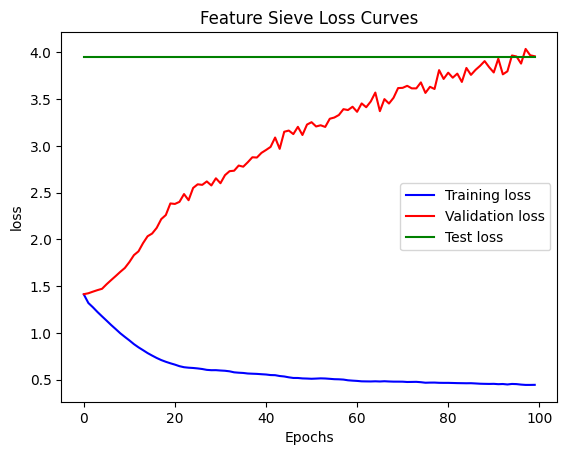

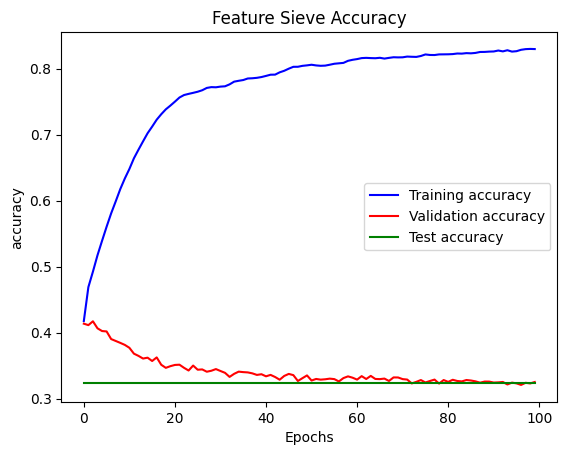

In [14]:
plot_loss_curves(train_loss, val_loss, test_loss, model_name = "Feature Sieve Loss Curves", metric = "loss")
plot_loss_curves(train_accs, val_accs, test_accs, model_name = "Feature Sieve Accuracy", metric = "accuracy")

## Architecture 2:
Auxilary network connected to the 2nd convolutional layer

In [14]:
class Feature_Sieve2(nn.Module):
    def __init__(self, num_channels, num_actions):
        super(Feature_Sieve2, self).__init__()
        self.num_actions = num_actions

        #Main Network
        self.conv1 = nn.Conv2d(num_channels, 32, 8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, 4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, 3, stride=1)

        self.fc1 = nn.Linear(3136, 512)
        self.fc2 = nn.Linear(512, num_actions)

        #Aux network
        self.aux_fc1 = nn.Linear(5184, 512)
        self.aux_fc2 = nn.Linear(512, num_actions)

        self.params = nn.ModuleDict(
            {
                "main" : nn.ModuleList([self.conv1, self.conv2, self.conv3, self.fc1, self.fc2]),
                "aux" : nn.ModuleList([self.aux_fc1, self.aux_fc2]),
                "forget" : nn.ModuleList([self.conv1])
            }
        )

    def forward(self, x):
        x = F.relu(self.conv1(x))
        sh = F.relu(self.conv2(x))
        x = F.relu(self.conv3(sh))
        
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        aux = sh.reshape(sh.shape[0], -1)
        aux = F.relu(self.aux_fc1(aux))
        aux = self.aux_fc2(aux)

        return x, aux

In [21]:
# training Feature Sieve architecture 2
model = Feature_Sieve2(4, 6).to(device)
model, train_loss, train_accs, val_loss, val_accs = train_fs(model, train_dataloader, val_dataloader, verbose=False, epochs =100)
test_loss, test_acc = eval_fsmodel(model, test_dataloader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [2:36:22<00:00, 93.82s/it]


Test Loss: 7.041356086730957 Test Accuracy :0.32012


In [22]:
plot_losss_curves(train_loss, val_loss, test_loss, model_name = "Feature Sieve 2 Loss", metric = "Loss")
plot_loss_curves(train_accs, val_accs, test_acc, model_name = "Feature Sieve 2 Accuracy", metric = "Accuracy")

NameError: name 'plot_losss_curves' is not defined

In [16]:
#Hyper parameter tuning of the feature Sieve model
forget_lrs = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2]
forget_iters = [2, 5, 10, 20, 30, 50, 60, 70, 80, 90, 100]
lrs = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2]

# test_accs = []
# for forget_lr in forget_lrs:
#     print(f"Forget Lr: {forget_lr}")
#     model = Feature_Sieve(4, 6).to(device)
#     model, train_loss, train_accs, val_loss, val_accs = train_fs(model, train_dataloader, val_dataloader, verbose=False, epochs=5, lrs = [1e-3, 1e-3, forget_lr])
#     test_loss, test_acc = eval_fsmodel(model, test_dataloader)
#     test_accs.append(test_acc)

# best_forget_lr = forget_lrs[test_accs.index(max(test_accs))]
# print(f"Best Forget LR: {best_forget_lr}")

# test_accs = []
# for forget_iter in forget_iters:
#     print(f"Forget iter: {forget_iter}")
#     model = Feature_Sieve(4, 6).to(device)
#     model, train_loss, train_accs, val_loss, val_accs = train_fs(model, train_dataloader, val_dataloader, verbose=False, epochs=5, forget_iters=forget_iter, lrs=[1e-3,1e-3,best_forget_lr])
#     test_loss, test_acc = eval_fsmodel(model, test_dataloader)
#     test_accs.append(test_acc)

# best_forget_iter = forget_iters[test_accs.index(max(test_accs))]
# print(f"Best forget iter: {best_forget_iter}")

best_forget_lr = 0.0001
best_forget_iter = 10

test_accs = []
for lr in lrs:
    print(f"LR: {lr}")
    model = Feature_Sieve(4,6).to(device)
    model, train_loss, train_accs, val_loss, val_accs = train_fs(model, train_dataloader, val_dataloader, verbose = False, epochs=5, forget_iters=best_forget_iter, lrs=[lr, lr, best_forget_lr])
    test_loss, test_acc = eval_fsmodel(model, test_dataloader)
    test_accs.append(test_acc)

best_lr = lrs[test_accs.index(max(test_accs))]
print(f"Best Lr: {best_lr}")

LR: 1e-05


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [08:18<00:00, 99.73s/it]


Test Loss: 1.7731949090957642 Test Accuracy :0.22512
LR: 5e-05


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [08:23<00:00, 100.60s/it]


Test Loss: 1.437415599822998 Test Accuracy :0.40728
LR: 0.0001


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [08:22<00:00, 100.55s/it]


Test Loss: 1.4795513153076172 Test Accuracy :0.40472
LR: 0.0005


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [08:21<00:00, 100.40s/it]


Test Loss: 1.5752860307693481 Test Accuracy :0.40528
LR: 0.001


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [08:23<00:00, 100.78s/it]


Test Loss: 1.4900609254837036 Test Accuracy :0.40232
LR: 0.005


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [08:23<00:00, 100.63s/it]


Test Loss: 1.7889174222946167 Test Accuracy :0.18224
LR: 0.01


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [08:23<00:00, 100.68s/it]


Test Loss: 1.6700743436813354 Test Accuracy :0.27608
LR: 0.05


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [08:20<00:00, 100.00s/it]


Test Loss: 1.790500283241272 Test Accuracy :0.18224
Best Lr: 5e-05


In [15]:
#Training a CNN model with the Early stopper
best_lr_cnn = 3e-5

model = CNN(4, 6).to(device)
model, train_loss, train_acc, val_loss, val_acc = train_cnn(model, train_dataloader, val_dataloader, epochs = 20, verbose=False, early_stop = True, lr=best_lr_cnn, min_delta = 0.1)
test_loss, test_acc = eval_cnn(model, test_dataloader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [19:53<00:00, 59.67s/it]


Test Loss: 1.9342814683914185 Accuracy:0.36892


In [16]:
# Training the Feature Sieve model with an Early Stopper
best_forget_lr = 0.0001
best_forget_iter = 10
best_lr = 5e-5

model = Feature_Sieve(4, 6).to(device)
model, train_loss_fs, train_acc_fs, val_loss_fs, val_acc_fs = train_fs(model, train_dataloader, val_dataloader, epochs = 20, verbose = False, early_stop = True, lrs = [best_lr, best_lr, best_forget_lr], forget_iters= best_forget_iter, min_delta = 0.1)
test_loss_fs, test_acc_fs = eval_fsmodel(model, test_dataloader)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [33:55<00:00, 101.80s/it]


Test Loss: 1.7054579257965088 Test Accuracy :0.3708


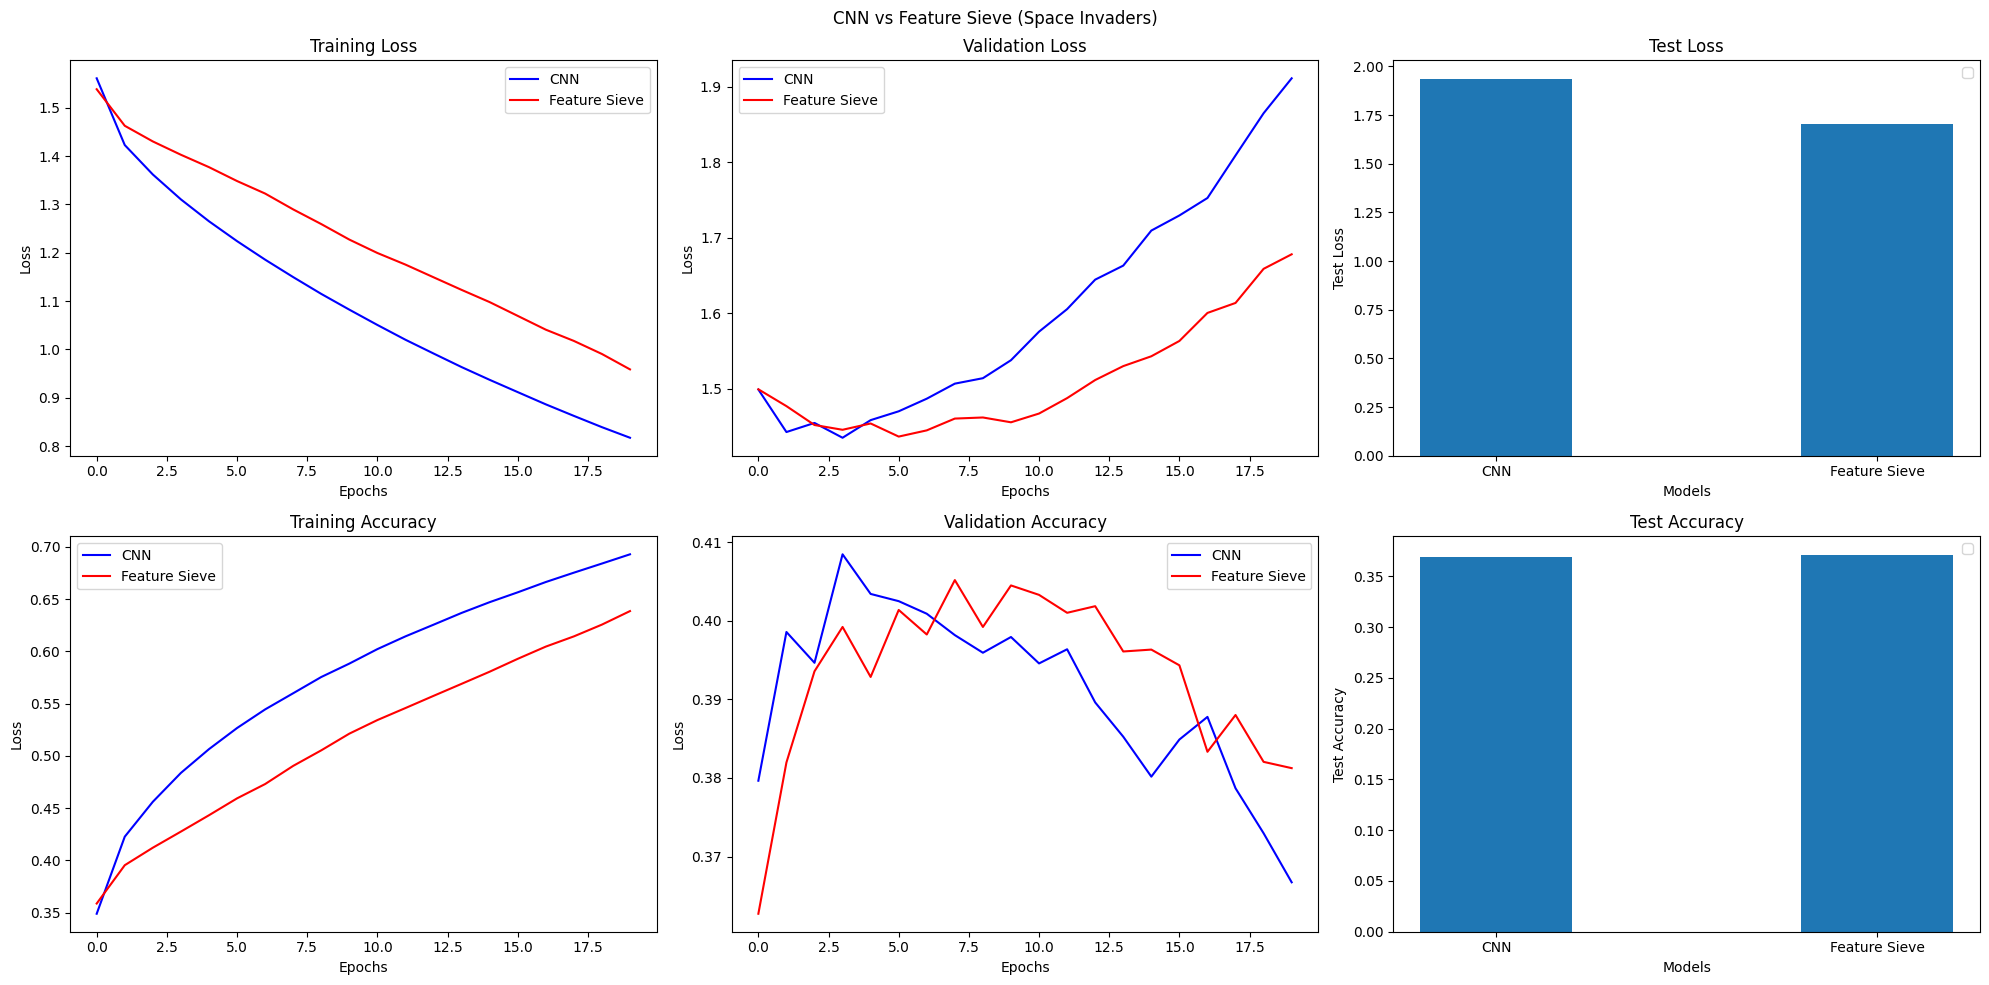

In [23]:
# Plotting the Comparisons
plt.rcParams["figure.figsize"] = (20, 10)
fig, ax = plt.subplots(2, 3)
fig.suptitle("CNN vs Feature Sieve (Space Invaders)")

# Training Loss
ax[0,0].plot(range(len(train_loss)), train_loss, color = "blue", label = "CNN")
ax[0,0].plot(range(len(train_loss_fs)), train_loss_fs,color = "red", label= "Feature Sieve")
ax[0,0].set_xlabel("Epochs")
ax[0,0].set_ylabel("Loss")
ax[0,0].set_title("Training Loss")
ax[0,0].legend()

#Validation Loss
ax[0,1].plot(range(len(val_loss)), val_loss, color = "blue", label = "CNN")
ax[0,1].plot(range(len(val_loss_fs)), val_loss_fs, color = "red", label= "Feature Sieve")
ax[0,1].set_xlabel("Epochs")
ax[0,1].set_ylabel("Loss")
ax[0,1].set_title("Validation Loss")
ax[0,1].legend()

#Training  Accuracy
ax[1,0].plot(range(len(train_acc)), train_acc, color = "blue", label = "CNN")
ax[1,0].plot(range(len(train_acc_fs)), train_acc_fs,color = "red", label= "Feature Sieve")
ax[1,0].set_xlabel("Epochs")
ax[1,0].set_ylabel("Loss")
ax[1,0].set_title("Training Accuracy")
ax[1,0].legend()

#Validation Accuracy
ax[1,1].plot(range(len(val_loss)), val_acc, color = "blue", label = "CNN")
ax[1,1].plot(range(len(val_loss_fs)), val_acc_fs, color = "red", label= "Feature Sieve")
ax[1,1].set_xlabel("Epochs")
ax[1,1].set_ylabel("Loss")
ax[1,1].set_title("Validation Accuracy")
ax[1,1].legend()

#Test Loss:
models = ["CNN", "Feature Sieve"]
test_losses = [test_loss, test_loss_fs]
ax[0,2].bar(models, test_losses, width = 0.4)
ax[0,2].set_xlabel("Models")
ax[0,2].set_ylabel("Test Loss")
ax[0,2].set_title("Test Loss")
ax[0,2].legend()

# Test accuracy
test_accs = [test_acc, test_acc_fs]
ax[1,2].bar(models, test_accs, width = 0.4)
ax[1,2].set_xlabel("Models")
ax[1,2].set_ylabel("Test Accuracy")
ax[1,2].set_title("Test Accuracy")
ax[1,2].legend()

plt.tight_layout()
plt.savefig("./Outputs/cnn_vs_fs.png")
plt.show()

In [24]:
# saving all the observations
np.save("./Datasets/space_invaders_obs.npy", observations)
np.save("./Datasets/space_invaders_actions.npy", actions)